## Machine Learning 프로젝트 수행을 위한 코드 구조화

`(분류, 회귀 Task)`

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [162]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = "feature_importance" # "correlation" / "feature_importance" / "PCA"
pd.set_option('display.max_columns', 600)

In [126]:
# 데이터를 불러옵니다.
base_path = "datas/mercedes-benz-greener-manufacturing/"
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")

In [127]:
train[train.isnull().any(axis=1)]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [128]:
test[test.isnull().any(axis=1)]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


In [129]:
temp = train.columns[10:]
temp

Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)

In [130]:
card1 = train.columns[train.nunique() == 1]
card1

Index(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293',
       'X297', 'X330', 'X347'],
      dtype='object')

In [131]:
binary_features = np.setdiff1d(temp, card1)
print("%d features - %d features = %d binary features" % (len(temp), len(card1), len(binary_features)))

368 features - 12 features = 356 binary features


In [132]:
categorical_features = train.columns[2:10]
categorical_features

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'], dtype='object')

In [133]:
total = pd.concat([train, test])
split_point = len(train)
total_OHE = pd.get_dummies(data=total, columns=categorical_features)
y = train.y
tempX = total_OHE.drop(columns=["ID", "y"])
tempX = tempX.drop(columns=card1)
trainX = tempX[:split_point]
testX = tempX[split_point:]
print(trainX.shape, testX.shape, y.shape)

(4209, 567) (4209, 567) (4209,)


In [134]:
trainX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,X0_a,X0_aa,X0_ab,X0_ac,X0_ad,X0_ae,X0_af,X0_ag,X0_ai,X0_aj,X0_ak,X0_al,X0_am,X0_an,X0_ao,X0_ap,X0_aq,X0_as,X0_at,X0_au,X0_av,X0_aw,X0_ax,X0_ay,X0_az,X0_b,X0_ba,X0_bb,X0_bc,X0_c,X0_d,X0_e,X0_f,X0_g,X0_h,X0_i,X0_j,X0_k,X0_l,X0_m,X0_n,X0_o,X0_p,X0_q,X0_r,X0_s,X0_t,X0_u,X0_v,X0_w,X0_x,X0_y,X0_z,X1_a,X1_aa,X1_ab,X1_b,X1_c,X1_d,X1_e,X1_f,X1_g,X1_h,X1_i,X1_j,X1_k,X1_l,X1_m,X1_n,X1_o,X1_p,X1_q,X1_r,X1_s,X1_t,X1_u,X1_v,X1_w,X1_y,X1_z,X2_a,X2_aa,X2_ab,X2_ac,X2_ad,X2_ae,X2_af,X2_ag,X2_ah,X2_ai,X2_aj,X2_ak,X2_al,X2_am,X2_an,X2_ao,X2_ap,X2_aq,X2_ar,X2_as,X2_at,X2_au,X2_av,X2_aw,X2_ax,X2_ay,X2_b,X2_c,X2_d,X2_e,X2_f,X2_g,X2_h,X2_i,X2_j,X2_k,X2_l,X2_m,X2_n,X2_o,X2_p,X2_q,X2_r,X2_s,X2_t,X2_u,X2_w,X2_x,X2_y,X2_z,X3_a,X3_b,X3_c,X3_d,X3_e,X3_f,X3_g,X4_a,X4_b,X4_c,X4_d,X5_a,X5_aa,X5_ab,X5_ac,X5_ad,X5_ae,X5_af,X5_ag,X5_ah,X5_b,X5_c,X5_d,X5_f,X5_g,X5_h,X5_i,X5_j,X5_k,X5_l,X5_m,X5_n,X5_o,X5_p,X5_q,X5_r,X5_s,X5_t,X5_u,X5_v,X5_w,X5_x,X5_y,X5_z,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Fa

In [135]:
testX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,X0_a,X0_aa,X0_ab,X0_ac,X0_ad,X0_ae,X0_af,X0_ag,X0_ai,X0_aj,X0_ak,X0_al,X0_am,X0_an,X0_ao,X0_ap,X0_aq,X0_as,X0_at,X0_au,X0_av,X0_aw,X0_ax,X0_ay,X0_az,X0_b,X0_ba,X0_bb,X0_bc,X0_c,X0_d,X0_e,X0_f,X0_g,X0_h,X0_i,X0_j,X0_k,X0_l,X0_m,X0_n,X0_o,X0_p,X0_q,X0_r,X0_s,X0_t,X0_u,X0_v,X0_w,X0_x,X0_y,X0_z,X1_a,X1_aa,X1_ab,X1_b,X1_c,X1_d,X1_e,X1_f,X1_g,X1_h,X1_i,X1_j,X1_k,X1_l,X1_m,X1_n,X1_o,X1_p,X1_q,X1_r,X1_s,X1_t,X1_u,X1_v,X1_w,X1_y,X1_z,X2_a,X2_aa,X2_ab,X2_ac,X2_ad,X2_ae,X2_af,X2_ag,X2_ah,X2_ai,X2_aj,X2_ak,X2_al,X2_am,X2_an,X2_ao,X2_ap,X2_aq,X2_ar,X2_as,X2_at,X2_au,X2_av,X2_aw,X2_ax,X2_ay,X2_b,X2_c,X2_d,X2_e,X2_f,X2_g,X2_h,X2_i,X2_j,X2_k,X2_l,X2_m,X2_n,X2_o,X2_p,X2_q,X2_r,X2_s,X2_t,X2_u,X2_w,X2_x,X2_y,X2_z,X3_a,X3_b,X3_c,X3_d,X3_e,X3_f,X3_g,X4_a,X4_b,X4_c,X4_d,X5_a,X5_aa,X5_ab,X5_ac,X5_ad,X5_ae,X5_af,X5_ag,X5_ah,X5_b,X5_c,X5_d,X5_f,X5_g,X5_h,X5_i,X5_j,X5_k,X5_l,X5_m,X5_n,X5_o,X5_p,X5_q,X5_r,X5_s,X5_t,X5_u,X5_v,X5_w,X5_x,X5_y,X5_z,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Fa

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

<Axes: xlabel='X1', ylabel='count'>

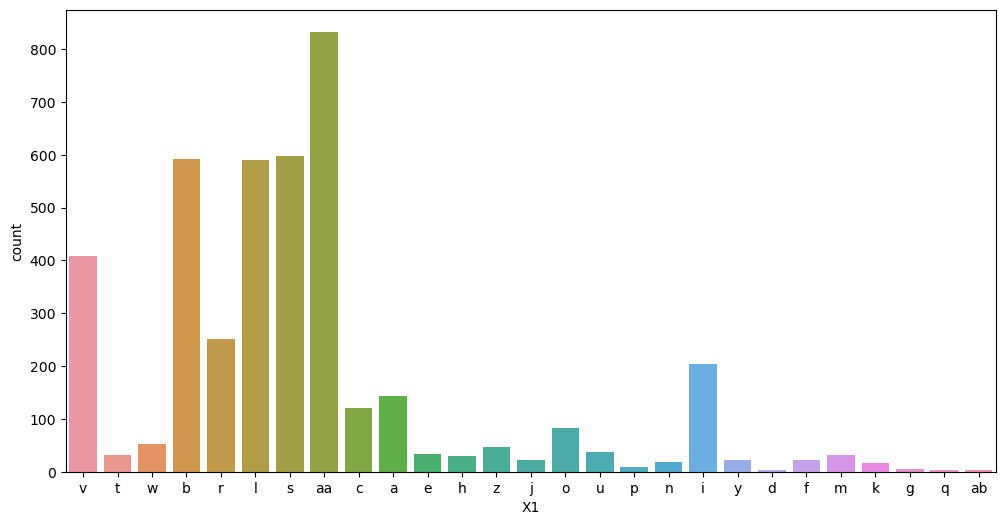

In [136]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x="X1")

<Axes: xlabel='X19', ylabel='Count'>

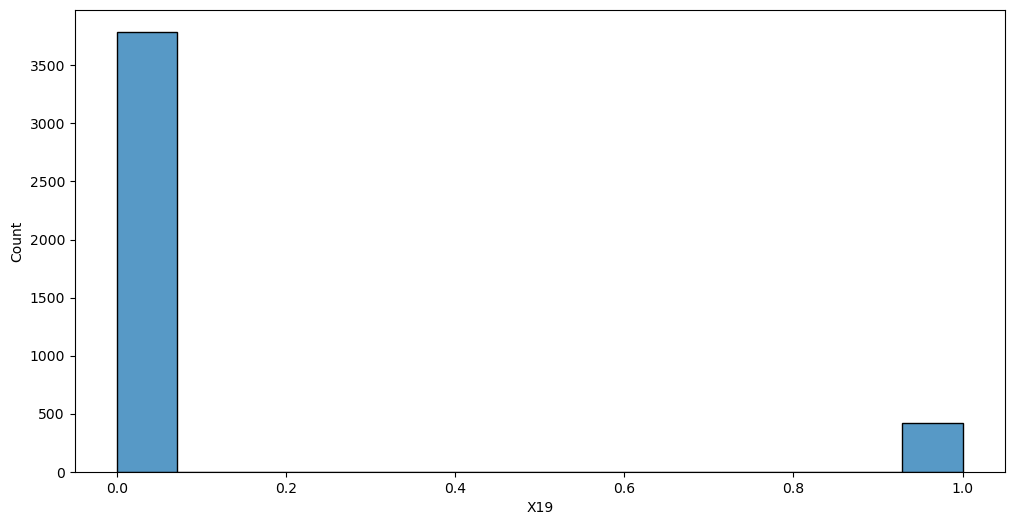

In [137]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x="X19")


In [138]:
train['X4'].value_counts()

X4
d    4205
a       2
b       1
c       1
Name: count, dtype: int64

In [139]:
## On your Own
# data.column.value_counts()
# sns.countplot()
# sns.histplot()
# ...

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [140]:
# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.

corr = train.corr(numeric_only=True)
corr

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
ID,1.000000,-0.055108,0.001602,NaN,0.058988,-0.031917,-0.025438,0.002237,-0.036480,-0.038171,-0.027063,-0.012762,0.063216,-0.029946,-0.096610,-0.010612,-0.008972,-0.048634,0.004214,0.030967,0.004175,0.015264,-0.040157,0.013217,0.015306,-0.008026,-0.040157,0.011691,-0.040157,0.256003,0.015306,0.018588,-0.013301,-0.022712,0.020923,-0.074500,-0.026850,0.012121,-0.034911,0.017011,-0.005676,0.040512,0.035067,0.022614,0.089264,0.000675,-0.006147,0.009491,0.015347,-0.041790,-0.020662,0.029059,-0.014606,0.017056,0.023260,-0.013670,-0.026285,0.023848,0.042702,-0.015103,0.042323,-0.000156,0.050365,-0.000898,0.004978,0.024365,0.000675,-0.007273,0.043475,0.002817,-0.014986,-0.015616,-0.000391,0.020186,0.050365,-0.019790,0.005876,-0.015406,-0.003192,-0.007429,-0.004421,-0.012891,0.017239,NaN,-0.004421,-0.004699,0.047778,0.001968,0.005285,0.008990,0.023613,-0.025072,0.089264,0.036747,0.007142,0.013155,-0.034735,NaN,-0.001316,-0.004779,-0.015865,-0.012837,-0.009420,0.017011,0.047947,-0.017450,0.003014,0.027489,0.002249,0.002249,-0.022614,-0.003192,0.005643,0.006030,-0.007121,0.061431,-0.002184,-0.008170,-0.005676,0.008170,-0.037022,0.034093,-0.063950,0.017011,0.009187,-0.000675,-0.026913,-0.005909,-0.082273,-0.005098,-0.011025,0.002397,-0.044740,0.078314,0.006902,-0.005909,0.017011,0.029152,0.038799,-0.024079,-0.019254,0.003737,-0.008364,0.040947,-0.002179,0.002179,-0.002397,-0.037332,-0.022460,-0.008401,-0.001761,0.016592,-0.010831,-0.011175,0.014766,0.000706,0.001100,-0.037129,-0.000541,0.001510,0.017056,-0.022592,0.010596,-0.032519,-0.074582,0.026306,0.033728,0.009718,0.030096,-0.022941,0.019076,-0.017838,-0.023849,0.030359,0.029084,-0.029660,-0.008905,0.004997,-0.037283,0.019787,-0.029084,-0.006429,-0.011499,0.039634,0.013077,-0.009420,0.002252,-0.038345,-0.010981,-0.007754,-0.026602,0.026602,0.000297,0.022472,0.004107,0.023971,-0.012257,-0.010038,-0.003335,0.042702,0.089264,-0.012556,0.017056,-0.003988,-0.008044,0.040697,0.016666,-0.000461,0.017011,-0.007054,-0.002038,0.014475,-0.019254,-0.007121,0.003242,-0.000097,-0.026012,0.016960,0.004175,NaN,-0.062625,NaN,-0.032544,-0.052728,-0.028826,0.089264,-0.063217,0.049119,-0.004421,-0.003192,0.050365,-0.007429,-0.016100,-0.010981,0.029059,-0.005186,0.030320,-0.037718,

In [141]:
trainX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,X0_a,X0_aa,X0_ab,X0_ac,X0_ad,X0_ae,X0_af,X0_ag,X0_ai,X0_aj,X0_ak,X0_al,X0_am,X0_an,X0_ao,X0_ap,X0_aq,X0_as,X0_at,X0_au,X0_av,X0_aw,X0_ax,X0_ay,X0_az,X0_b,X0_ba,X0_bb,X0_bc,X0_c,X0_d,X0_e,X0_f,X0_g,X0_h,X0_i,X0_j,X0_k,X0_l,X0_m,X0_n,X0_o,X0_p,X0_q,X0_r,X0_s,X0_t,X0_u,X0_v,X0_w,X0_x,X0_y,X0_z,X1_a,X1_aa,X1_ab,X1_b,X1_c,X1_d,X1_e,X1_f,X1_g,X1_h,X1_i,X1_j,X1_k,X1_l,X1_m,X1_n,X1_o,X1_p,X1_q,X1_r,X1_s,X1_t,X1_u,X1_v,X1_w,X1_y,X1_z,X2_a,X2_aa,X2_ab,X2_ac,X2_ad,X2_ae,X2_af,X2_ag,X2_ah,X2_ai,X2_aj,X2_ak,X2_al,X2_am,X2_an,X2_ao,X2_ap,X2_aq,X2_ar,X2_as,X2_at,X2_au,X2_av,X2_aw,X2_ax,X2_ay,X2_b,X2_c,X2_d,X2_e,X2_f,X2_g,X2_h,X2_i,X2_j,X2_k,X2_l,X2_m,X2_n,X2_o,X2_p,X2_q,X2_r,X2_s,X2_t,X2_u,X2_w,X2_x,X2_y,X2_z,X3_a,X3_b,X3_c,X3_d,X3_e,X3_f,X3_g,X4_a,X4_b,X4_c,X4_d,X5_a,X5_aa,X5_ab,X5_ac,X5_ad,X5_ae,X5_af,X5_ag,X5_ah,X5_b,X5_c,X5_d,X5_f,X5_g,X5_h,X5_i,X5_j,X5_k,X5_l,X5_m,X5_n,X5_o,X5_p,X5_q,X5_r,X5_s,X5_t,X5_u,X5_v,X5_w,X5_x,X5_y,X5_z,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Fa

In [142]:
trainX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,X0_a,X0_aa,X0_ab,X0_ac,X0_ad,X0_ae,X0_af,X0_ag,X0_ai,X0_aj,X0_ak,X0_al,X0_am,X0_an,X0_ao,X0_ap,X0_aq,X0_as,X0_at,X0_au,X0_av,X0_aw,X0_ax,X0_ay,X0_az,X0_b,X0_ba,X0_bb,X0_bc,X0_c,X0_d,X0_e,X0_f,X0_g,X0_h,X0_i,X0_j,X0_k,X0_l,X0_m,X0_n,X0_o,X0_p,X0_q,X0_r,X0_s,X0_t,X0_u,X0_v,X0_w,X0_x,X0_y,X0_z,X1_a,X1_aa,X1_ab,X1_b,X1_c,X1_d,X1_e,X1_f,X1_g,X1_h,X1_i,X1_j,X1_k,X1_l,X1_m,X1_n,X1_o,X1_p,X1_q,X1_r,X1_s,X1_t,X1_u,X1_v,X1_w,X1_y,X1_z,X2_a,X2_aa,X2_ab,X2_ac,X2_ad,X2_ae,X2_af,X2_ag,X2_ah,X2_ai,X2_aj,X2_ak,X2_al,X2_am,X2_an,X2_ao,X2_ap,X2_aq,X2_ar,X2_as,X2_at,X2_au,X2_av,X2_aw,X2_ax,X2_ay,X2_b,X2_c,X2_d,X2_e,X2_f,X2_g,X2_h,X2_i,X2_j,X2_k,X2_l,X2_m,X2_n,X2_o,X2_p,X2_q,X2_r,X2_s,X2_t,X2_u,X2_w,X2_x,X2_y,X2_z,X3_a,X3_b,X3_c,X3_d,X3_e,X3_f,X3_g,X4_a,X4_b,X4_c,X4_d,X5_a,X5_aa,X5_ab,X5_ac,X5_ad,X5_ae,X5_af,X5_ag,X5_ah,X5_b,X5_c,X5_d,X5_f,X5_g,X5_h,X5_i,X5_j,X5_k,X5_l,X5_m,X5_n,X5_o,X5_p,X5_q,X5_r,X5_s,X5_t,X5_u,X5_v,X5_w,X5_x,X5_y,X5_z,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Fa

#### 다중공선성 처리

In [143]:
# 1. correlation

# 중복정보가 있는 column 제거하기 위해 상관계수를 확인해봅니다.
def remove_collinearity(X, threshold):
    """
    X : feature matrix
    threshold : 다중공선성을 제거할 column을 고르는 기준 값. [0, 1]
    """
    
    corr = X.corr()
    candidate_cols = []
    
    for x in corr.iterrows():
        idx, row = x[0], x[1] # decoupling tuple
        # 해당 row는 이미 처리가 되어서 볼 필요가 없다.
        if idx in candidate_cols:
            continue
        #print(row[row > 0.7].index[1:])
        candidates = row[row > threshold].index[1:]

        # 자기 자신을 제외하고 threshold를 넘는 column이 있다면,
        if len(candidates) != 0:
            for col in candidates:
                candidate_cols.append(col)           
    
    return candidate_cols

def find_feature_importance(X, model, show_plot):

    feat_names = X.columns.values
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:20]
    
    plt.figure(figsize=(12,12))
    plt.title("Feature importances")
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
    plt.xlim([-1, len(indices)])
    plt.show()
    
    important_features = X.columns[importances >= 0.005]
    return important_features
    
def apply_PCA(X, show_plot):
    from sklearn.decomposition import PCA
    # training data와 test data를 모두 PCA를 이용하여 차원 감소를 수행합니다.
    pca = PCA(n_components=0.90) # 원래 데이터의 90%를 보존하는 차원.
    pca_090 = pca.fit(X) # 학습 및 변환
    reduced_X = pca_090.transform(X)
    print(reduced_X.shape)
    
    if show_plot:
        labels = [f"PC{x}" for x in range(1, reduced_X.shape[1]+1)]
        pca_090_variance = np.round(pca_090.explained_variance_ratio_.cumsum()*100, decimals=1)
        plt.figure(figsize=(25,5))
        plt.bar(x=range(1, len(pca_090_variance)+1), height=pca_090_variance, tick_label=labels)

        plt.xticks(rotation=90, color='indigo', size=15)
        plt.yticks(rotation=0, color='indigo', size=15)
        plt.title('Scree Plot',color='tab:orange', fontsize=25)
        plt.xlabel('Principal Components', {'color': 'tab:orange', 'fontsize':15})
        plt.ylabel('Cumulative percentage of explained variance ', {'color': 'tab:orange', 'fontsize':15})
        plt.show()
        
        X_train_pca_df = pd.DataFrame(reduced_X, columns=labels)
        display(X_train_pca_df)

    return pca_090, X_train_pca_df

(4209, 94)


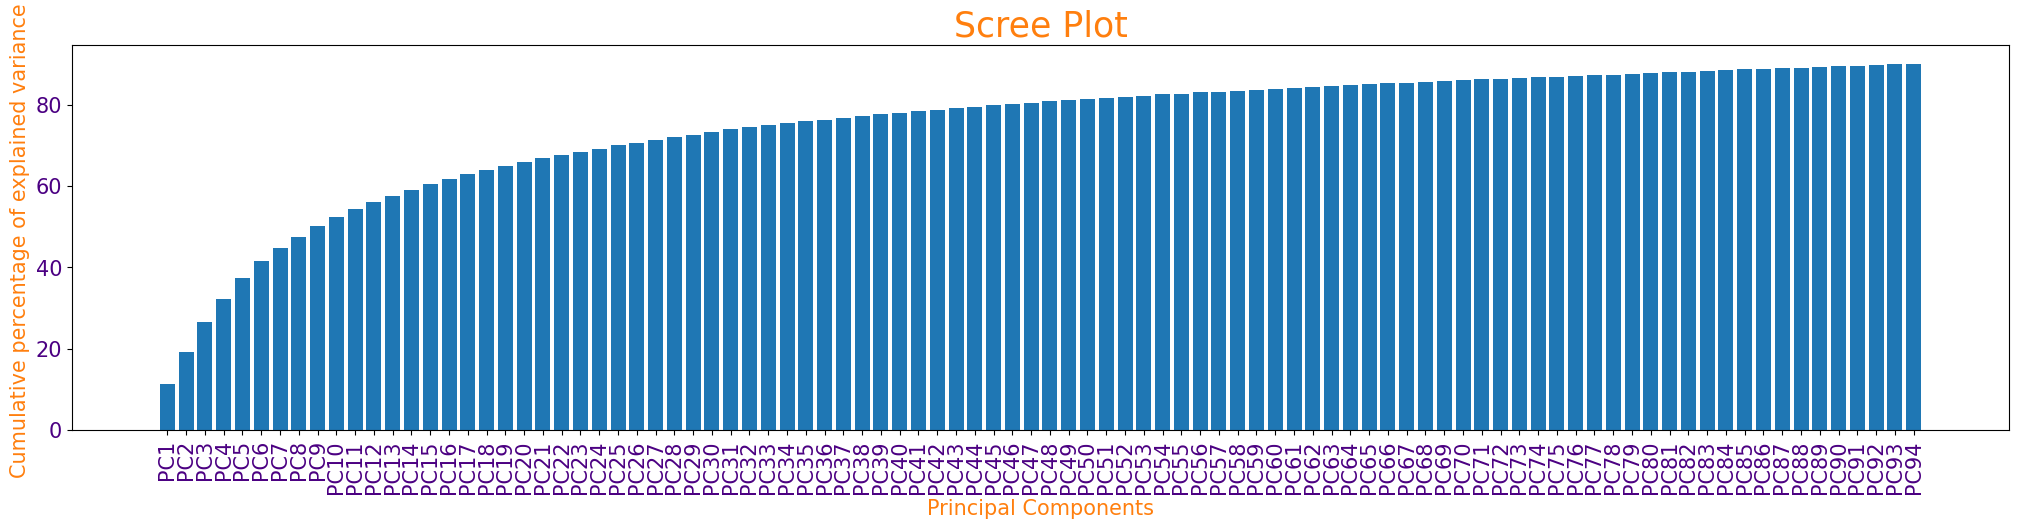

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94
0,0.850248,-1.252515,2.021640,0.865224,1.592171,-0.056846,0.563840,-1.030709,0.205190,-0.264539,-1.753161,-0.771512,0.050685,0.108639,0.036740,0.295702,-0.518997,-0.475996,-0.527253,0.405748,-0.331849,1.107724,-0.221106,1.329966,-0.681128,-0.434284,0.068605,0.234205,-0.415363,0.314979,0.597014,-0.114645,-0.814521,-0.398345,1.480487,-0.351260,-0.511761,-0.906068,0.204449,0.132113,-0.089727,0.239500,0.044624,-0.136684,-0.402983,0.014723,0.698913,-0.459452,0.526933,0.130354,0.446449,0.322912,-1.027151,-0.373593,0.768788,1.041258,0.032579,0.112011,-0.900424,-0.525092,0.140007,-0.032731,0.522537,0.003642,0.280575,0.171260,-0.176449,0.498165,1.482780,0.265638,0.468604,0.275828,0.037418,-0.451913,0.713778,-0.046437,0.183927,-0.027721,-0.223442,-0.116771,0.132987,0.239647,0.101862,-0.267083,-0.034434,0.102761,0.368126,0.061246,0.132832,0.091619,0.335127,0.532029,0.244260,-0.016116
1,-0.109302,-1.299662,-0.045801,-0.796931,0.277976,0.140880,1.108070,-0.726633,-0.032185,0.612267,-0.004163,1.040533,-0.074608,0.499726,-0.981805,-0.648140,-0.005693,0.095872,0.854458,-0.193083,-0.880463,0.622407,-0.337668,1.369789,0.032540,-0.006701,0.219100,0.481085,0.273802,0.194196,0.405620,0.448031,-0.330018,0.337574,0.294404,0.086806,-0.005619,-0.035793,-0.142424,0.067265,-0.335782,0.422132,0.196163,-0.252838,0.189187,-0.229988,0.124499,0.191831,0.282526,-0.006339,-0.103009,-0.021311,-0.138206,-0.354789,0.348618,-0.039251,-0.337813,0.254832,0.221495,0.059842,0.120834,0.262444,0.360843,0.386368,0.217253,-0.101021,0.244932,0.353198,-0.036158,-0.268612,0.231544,0.174176,0.069999,-0.186734,0.064140,-0.310681,-0.119946,0.175628,0.026706,0.256868,0.099775,0.125294,-0.034944,0.116158,0.026773,-0.157430,0.256661,0.073930,-0.237603,-0.024763,0.235889,-0.026481,-0.000175,0.190709
2,-0.673653,-2.367697,1.787792,2.345645,0.356806,3.753878,-1.188809,0.679651,-0.924719,-0.215840,0.360043,-0.326239,0.258781,0.198783,0.294974,0.844870,-0.353295,-0.826777,0.562528,0.591308,0.884110,-0.547418,0.562774,0.673203,-0.039616,0.573430,-0.381709,-0.194255,-0.264001,0.140752,0.260809,-0.025316,-0.039097,0.243070,-0.461306,0.505456,-0.022244,0.188668,0.233969,-0.158305,0.127389,-0.053169,-0.253812,0.081167,-0.082499,-0.286286,-0.354994,-0.193523,0.098477,0.481791,0.239575,0.134134,-0.520605,0.016756,-0.311219,0.205597,-0.113905,-0.089662,0.093804,-0.104139,0.011049,-0.379608,-0.171106,0.042929,-0.009160,0.318695,-0.048783,0.295690,-0.091928,-0.019851,0.221009,-0.029525,0.552852,-0.138001,-0.060205,-0.063129,-0.083061,-0.176565,-0.064415,0.249972,0.217608,0.027765,0.009250,0.253571,-0.046264,0.169516,-0.197010,0.159841,0.081919,0.363910,-0.133875,0.049563,0.391101,-0.014445
3,-0.480940,-2.695789,0.524340,2.881771,-0.485304,3.765186,-0.307380,-0.014646,-1.239946,0.254642,0.275338,0.172519,-0.345895,0.763317,0.240081,0.359322,0.274123,-0.778922,0.820521,0.625796,-0.354778,-0.309101,0.241520,-0.221266,-1.137301,-0.197163,0.159443,-0.154159,0.131004,-0.289323,0.039472,0.378078,-0.506259,0.283392,-0.895172,0.085903,0.200613,-0.301324,0.053088,-0.244732,0.121105,0.566449,-0.096378,-0.324066,-0.571715,0.005708,0.118967,-0.075534,-0.202754,0.421397,-0.570885,0.102528,0.135056,-0.366875,0.228108,-0.673973,0.089801,0.192998,-0.006606,0.383121,-0.211634,-0.162343,0.025530,0.261263,0.034406,-0.162794,-0.038596,0.188354,-0.099810,-0.084658,0.153995,0.024007,-0.054403,0.181513,-0.002176,-0.068440,-0.148191,-0.116241,0.114116,0.047865,0.092929,-0.005067,0.078799,0.024917,-0.063783,0.081018,-0.027836,-0.006426,-0.072461,-0.010365,0.121859,-0.

(4209, 94)


In [144]:
# PCA 적용
if feature_reducing == "correlation":
    threshold = 0.7
    correlated_features = remove_collinearity(trainX, threshold)
    correlated_features = set(correlated_features) # 중복 제거
    print("%d Correlation features over %.2f" % (len(correlated_features), threshold))
    
    X = trainX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    show_plot = True
    model = RandomForestRegressor(max_features="sqrt", n_jobs=-1, random_state=0xC0FFEE)
    model.fit(trainX, y)
    important_features = find_feature_importance(trainX, model, show_plot)
    X = trainX[important_features]
    print(X.shape)
    print(important_features)
    
elif feature_reducing == "PCA":
    show_plot = True
    pca_model, X = apply_PCA(trainX, show_plot)
    print(X.shape)

### 4. 학습 데이터 분할

In [145]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.
# train : test = 8 : 2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3788, 94) (421, 94) (3788,) (421,)


### 5. 학습 및 평가

In [146]:
model = RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=0xC0FFEE)
model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=12648430)

In [147]:
from sklearn.metrics import r2_score
evaluation_metric = r2_score

In [148]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_score = evaluation_metric(y_train, pred_train)
test_score = evaluation_metric(y_test, pred_test)

print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.9040104200823456
Test score:  0.4567041109351092


In [149]:
# For Regression

def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 8, 30)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=0xC0FFEE)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = evaluation_metric(y_val, preds)
        scores.append(score)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [150]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

rf_study = optuna.create_study(study_name="RF", direction="maximize") # regression task에서 R^2를 최대화!
rf_study.optimize(opt_func, n_trials=30)

[I 2023-11-24 16:46:41,764] A new study created in memory with name: RF
[I 2023-11-24 16:46:47,287] Trial 0 finished with value: 0.4867395653219611 and parameters: {'n_estimators': 104, 'max_depth': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4867395653219611.
[I 2023-11-24 16:46:51,404] Trial 1 finished with value: 0.487581377764155 and parameters: {'n_estimators': 73, 'max_depth': 16, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.487581377764155.
[I 2023-11-24 16:47:03,373] Trial 2 finished with value: 0.48558474262793283 and parameters: {'n_estimators': 196, 'max_depth': 21, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.487581377764155.
[I 2023-11-24 16:47:05,659] Trial 3 finished with value: 0.4745665476976302 and parameters: {'n_estimators': 50, 'max_depth': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.487581377764155.
[I 2023-11-24 16:47:13,786] Trial 4 finished with value: 0.48315666780532707 and parameters: {'n_estimators': 148, 'm

In [151]:
rf_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_n_estimators,state
0,0,0.486740,2023-11-24 16:46:41.766193,2023-11-24 16:46:47.287188,0 days 00:00:05.520995,15,sqrt,104,COMPLETE
1,1,0.487581,2023-11-24 16:46:47.288188,2023-11-24 16:46:51.404188,0 days 00:00:04.116000,16,sqrt,73,COMPLETE
2,2,0.485585,2023-11-24 16:46:51.405189,2023-11-24 16:47:03.373980,0 days 00:00:11.968791,21,sqrt,196,COMPLETE
3,3,0.474567,2023-11-24 16:47:03.374981,2023-11-24 16:47:05.659983,0 days 00:00:02.285002,10,sqrt,50,COMPLETE
4,4,0.483157,2023-11-24 16:47:05.660981,2023-11-24 16:47:13.785980,0 days 00:00:08.124999,19,sqrt,148,COMPLETE
5,5,0.486943,2023-11-24 16:47:13.786980,2023-11-24 16:47:17.017984,0 days 00:00:03.231004,13,sqrt,63,COMPLETE
6,6,0.467879,2023-11-24 16:47:17.018981,2023-11-24 16:47:25.200991,0 days 00:00:08.182010,23,log2,186,COMPLETE
7,7,0.485845,2023-11-24 16:47:25.201984,2023-11-24 16:47:30.914981,0 days 00:00:05.712997,23,sqrt,92,COMPLETE
8,8,0.484241,2023-11-24 16:47:30.915980,2023-11-24 16:47:35.263985,0 days 00:00:04.348005,11,sqrt,106,COMPLETE
9,9,0.485522,2023-11-24 16:47:35.264987,2023-11-24 16:47:42.342980,0 days 00:00:07.077993,25,sqrt,114,COMPLETE


In [152]:
print("Best Score: %.4f" % rf_study.best_value) # best score 출력
print("Best params: ", rf_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.4889
Best params:  {'n_estimators': 105, 'max_depth': 16, 'max_features': 'sqrt'}


In [153]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(rf_study)

In [154]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(rf_study)

### 7. 테스트 및 제출 파일 생성

In [155]:
final_rf_model = RandomForestRegressor(n_estimators=rf_study.best_trial.params["n_estimators"],
                                 max_depth=rf_study.best_trial.params["max_depth"],
                                 max_features=rf_study.best_trial.params["max_features"])

final_rf_model.fit(X, y) # finalize model

RandomForestRegressor(max_depth=16, max_features='sqrt', n_estimators=105)

In [156]:
testX

,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X234,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X291,X292,X294,X295,X296,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,X0_a,X0_aa,X0_ab,X0_ac,X0_ad,X0_ae,X0_af,X0_ag,X0_ai,X0_aj,X0_ak,X0_al,X0_am,X0_an,X0_ao,X0_ap,X0_aq,X0_as,X0_at,X0_au,X0_av,X0_aw,X0_ax,X0_ay,X0_az,X0_b,X0_ba,X0_bb,X0_bc,X0_c,X0_d,X0_e,X0_f,X0_g,X0_h,X0_i,X0_j,X0_k,X0_l,X0_m,X0_n,X0_o,X0_p,X0_q,X0_r,X0_s,X0_t,X0_u,X0_v,X0_w,X0_x,X0_y,X0_z,X1_a,X1_aa,X1_ab,X1_b,X1_c,X1_d,X1_e,X1_f,X1_g,X1_h,X1_i,X1_j,X1_k,X1_l,X1_m,X1_n,X1_o,X1_p,X1_q,X1_r,X1_s,X1_t,X1_u,X1_v,X1_w,X1_y,X1_z,X2_a,X2_aa,X2_ab,X2_ac,X2_ad,X2_ae,X2_af,X2_ag,X2_ah,X2_ai,X2_aj,X2_ak,X2_al,X2_am,X2_an,X2_ao,X2_ap,X2_aq,X2_ar,X2_as,X2_at,X2_au,X2_av,X2_aw,X2_ax,X2_ay,X2_b,X2_c,X2_d,X2_e,X2_f,X2_g,X2_h,X2_i,X2_j,X2_k,X2_l,X2_m,X2_n,X2_o,X2_p,X2_q,X2_r,X2_s,X2_t,X2_u,X2_w,X2_x,X2_y,X2_z,X3_a,X3_b,X3_c,X3_d,X3_e,X3_f,X3_g,X4_a,X4_b,X4_c,X4_d,X5_a,X5_aa,X5_ab,X5_ac,X5_ad,X5_ae,X5_af,X5_ag,X5_ah,X5_b,X5_c,X5_d,X5_f,X5_g,X5_h,X5_i,X5_j,X5_k,X5_l,X5_m,X5_n,X5_o,X5_p,X5_q,X5_r,X5_s,X5_t,X5_u,X5_v,X5_w,X5_x,X5_y,X5_z,X6_a,X6_b,X6_c,X6_d,X6_e,X6_f,X6_g,X6_h,X6_i,X6_j,X6_k,X6_l,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,X8_k,X8_l,X8_m,X8_n,X8_o,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Fa

In [157]:
# PCA 적용
if feature_reducing == "correlation":
    test = testX.drop(columns=correlated_features)
    print(X.shape)
    
elif feature_reducing == "feature_importance":
    test = testX[important_features]
    print(X.shape)
    
elif feature_reducing == "PCA":
    test = pca_model.transform(testX)
    print(X.shape)

(4209, 94)


In [158]:
prediction = final_rf_model.predict(test)
prediction

c:\Users\dudcj\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



array([ 84.90695807,  97.35064726,  80.02114504, ...,  97.58030804,
       107.21045514,  93.52691044])

In [159]:
submission = pd.read_csv(base_path + "sample_submission.csv")
submission

,ID,y
0,1,100.669318
1,2,100.669318
2,3,100.669318
3,4,100.669318
4,5,100.669318
...,...,...
4204,8410,100.669318
4205,8411,100.669318
4206,8413,100.669318
4207,8414,100.669318


In [160]:
submission["y"] = prediction
submission

,ID,y
0,1,84.906958
1,2,97.350647
2,3,80.021145
3,4,84.581908
4,5,115.013280
...,...,...
4204,8410,104.809828
4205,8411,97.461230
4206,8413,97.580308
4207,8414,107.210455


In [161]:
submission.reset_index(drop=True).to_csv(f"rf_submission_{feature_reducing}.csv", index=False)

### 6. Hyper-parameter Tuning

> GridSearchCV

** LightGBM의 hyperparameter **

[Official Documentation] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

[Blog 1] https://smecsm.tistory.com/133

[Blog 2] https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

[Blog 3] https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [91]:
# GridSearchCV를 이용하여 가장 좋은 성능을 가지는 모델을 찾아봅시다. (이것은 첫번째엔 선택입니다.)
# Lightgbm은 hyper-parameter의 영향을 많이 받기 때문에, 저는 보통 맨처음에 한번 정도는 가볍게 GCV를 해봅니다.
# 성능 향상이 별로 없다면, lightgbm으로 돌린 대략적인 성능이 이 정도라고 생각하면 됩니다.
# 만약 성능 향상이 크다면, 지금 데이터는 hyper-parameter tuning을 빡빡하게 하면 성능 향상이 많이 이끌어 낼 수 있습니다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth" : [8, 16, None],
    "n_estimators" : [100, 300, 500],
    "max_bin" : [20],
    "learning_rate" : [0.001, 0.0025, 0.003],
    "objective" : ["regression"],
    "boosting_type" : ["gbdt"],
    "metric" : ["mae"],
    "sub_feature" : [0.345],
    "bagging_fraction" : [0.7, 0.75, 0.85],
    "bagging_freq" : [40],
    "num_leaves" : [256, 512],
    "min_data" : [500],
    "verbose" : [-1], # 필수
    "min_hessian" : [0.05],
    "feature_fraction_seed" : [2],
    "bagging_seed" : [3]
}


gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                  n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [ ]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_test = gcv.predict(x_test)

gcv_train_score = evaluation_metric(y_train, gcv_pred_train)
gcv_test_score = evaluation_metric(y_test, gcv_pred_test)

print("Train MAE Score : %.4f" % gcv_train_score)
print("Test MAE Score : %.4f" % gcv_test_score)

In [ ]:
print("Performance Gain") # 이걸로 성능 향상 확인.
print("in train : ", (train_score - gcv_train_score))
print("in test : ", (test_score - gcv_test_score))

> optuna를 사용해봅시다 !

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    n_estimators = 
    max_depth = 
    max_features = 
    
    
    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features)
    
    
    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K)
    losses = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = mean_absolute_error(y_val, preds)
        losses.append(loss)
    
    
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=5)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
model = RandomForestRegressor(n_estimators=study.best_trial.params["n_estimators"],
                                 max_depth=study.best_trial.params["max_depth"],
                                 max_features=study.best_trial.params["max_features"])

model.fit(X_train, y_train)
preds = model.predict(X_test)
preds

In [ ]:
X_test # 원본 데이터랑 id가 맞는지 확인 해보기!

In [ ]:
submission = pd.DataFrame() # submission을 생성합니다.
submission

In [ ]:
submission.reset_index(drop=True).to_csv("submission.csv", index=False)